# ActiveLLM demo
Use a generative LLM in an active learning loop. Since an active learning loop it very compute intensive, it is recommended to run this notebook in Google Colab: <a target="_blank" href="https://colab.research.google.com/github/MoritzLaurer/ActiveLLM/blob/main/ActiveLLM_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Install and load relevant packages

In [1]:
import sys
if sys.argv[0] != '/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/ipykernel_launcher.py':
    EXECUTION_COLAB = True
else:
    EXECUTION_COLAB = False
print("Terminal execution: ", EXECUTION_COLAB, "  (sys.argv[0]: ", sys.argv[0], ")")

Terminal execution:  False   (sys.argv[0]:  /Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/ipykernel_launcher.py )


In [2]:
if EXECUTION_COLAB:
    %pip install "transformers[sentencepiece]~=4.28"
    %pip install "datasets~=2.8"
    %pip install accelerate==0.18
    #%pip install "argilla[server, listeners]==1.1.1"

In [3]:
if EXECUTION_COLAB:
    # get the code for the active learning loop from github
    !rm -rf ActiveLLM  # delete directory in case it was previously imported and updates were made
    !git clone https://github.com/MoritzLaurer/ActiveLLM

In [4]:
if EXECUTION_COLAB:
    # info on the GPU you are using
    !nvidia-smi
    # info on available ram
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
if EXECUTION_COLAB:
    from google.colab import drive
    import os
    drive.mount('/content/drive', force_remount=False)
    #drive.flush_and_unmount()
    print(os.getcwd())
    os.chdir("/content/drive/My Drive/PhD/active-learning")
    print(os.getcwd())


In [5]:
## import relevant packages
import numpy as np
import pandas as pd
import torch
import datasets
import copy

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    AutoConfig, AutoModelForNextSentencePrediction, T5ForConditionalGeneration,
    TrainingArguments, Trainer
)

from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [6]:
## load/reload modules
import sys, os
if EXECUTION_COLAB:
    sys.path.insert(0, os.getcwd())
    from ActiveLLM.active_learner import ActiveLearner
    # reload in case of updates in active_learner.py
    import importlib
    from ActiveLLM import active_learner
    importlib.reload(active_learner)
    from ActiveLLM.active_learner import ActiveLearner
else:
    from active_learner import ActiveLearner
    # reload in case of updates in active_learner.py
    import importlib
    import active_learner
    importlib.reload(active_learner)
    from active_learner import ActiveLearner


## Set main arguments

In [7]:
DATASET = "pimpo"
MODEL_NAME = "MoritzLaurer/DeBERTa-v3-xsmall-mnli-fever-anli-ling-binary" #"MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
METHOD = "nli"
#MAX_SAMPLE = 10_000
N_SAMPLE_AL = 4
N_ITER_MAX = 2
DATE = 20230601
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)

TASK = "immigration"
SAMPLE_NO_TOPIC = 500
SAMPLE_OVERALL = 100
SAMPLE_PER_LABEL = 20


In [8]:
HYPER_PARAMS_DIC = {
    'lr_scheduler_type': 'linear', 'learning_rate': 2e-5, 'num_train_epochs': 2, 'seed': SEED_GLOBAL,
    'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8*2, 
    'warmup_ratio': 0.30, 'weight_decay': 0.01,
    #"include_inputs_for_metrics": True,
    # ! need to set this to true, otherwise seq2seq-trainer is not used https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/trainer_seq2seq.py#L246
    #"predict_with_generate": True,
    #"gradient_checkpointing": True,
    #"gradient_accumulation_steps": 2,
}
MODEL_MAX_LENGTH = 512 - 128
TRAINING_DIRECTORY = ""


## Load and clean data

In [9]:
## load data
if "squad_v2" in DATASET:
    from datasets import load_dataset
    dataset_squad_v2 = load_dataset("squad_v2")
    # dataset to df for easier processing
    df_train = dataset_squad_v2["train"].to_pandas()
    df_test = dataset_squad_v2["validation"].to_pandas()
    # create label_text column and clean values
    df_train["label_text"] = df_train["answers"].apply(lambda x: x["text"][0] if len(x["text"]) > 0 else "unanswerable" )
    df_test["label_text"] = df_test["answers"].apply(lambda x: x["text"][0] if len(x["text"]) > 0 else "unanswerable" )
elif "pimpo" in DATASET:
    if EXECUTION_COLAB:
        df = pd.read_csv(f"/content/drive/My Drive/PhD/active-learning/data/df_pimpo_samp_trans_m2m_100_1.2B.zip")   #(f"./data/df_pimpo_all.zip")
    else:
        df = pd.read_csv("/Users/moritzlaurer/Dropbox/PhD/Papers/meta-metrics/meta-metrics-repo/data-clean/df_pimpo_samp_trans_lemmatized_stopwords.zip", engine="python")
    df_cl = df.copy(deep=True)
else:
    raise Exception(f"Dataset name not found: {DATASET}")

In [10]:

if TASK == "integration":
    task_label_text = ["integration_supportive", "integration_sceptical", "integration_neutral", "no_topic"]
elif TASK == "immigration":
    task_label_text = ["immigration_supportive", "immigration_sceptical", "immigration_neutral", "no_topic"]


HYPO_LABEL_DIC = {
        "immigration_neutral": "The quote describes immigration neutrally without implied value judgement or describes the status quo of immigration, for example only stating facts or using technocratic language about immigration",
        "immigration_sceptical": "The quote describes immigration sceptically / disapprovingly. For example, the quote could mention the costs of immigration, be against migrant workers, state that foreign labour decreases natives' wages, that there are already enough refugees, refugees are actually economic migrants, be in favour of stricter immigration controls, exceptions to the freedom of movement in the EU.",
        "immigration_supportive": "The quote describes immigration favourably / supportively. For example, the quote could mention the benefits of immigration, the need for migrant workers, international obligations to take in refugees, protection of human rights, in favour of family reunification or freedom of movement in the EU.",
        "no_topic": "The quote is not about immigration.",
}

df_cl = df_cl[df_cl.label_text.isin(task_label_text)]
df_cl["label"] = df_cl["label_text"].factorize(sort=False)[0]
# label_map necessary downstream
label_map = {label_text: label for label, label_text in zip(np.unique(df_cl["label_text"].factorize(sort=False)[0]), df_cl["label_text"].factorize(sort=False)[1])}

# format text
df_cl["text_prepared"] = df_cl.text_preceding_trans.fillna("") + '  || The quote: "' + df_cl.text_original_trans.fillna("") + '" End of the quote ||  ' + df_cl.text_following_trans.fillna("")
#df_cl["text"] = df_cl.text_preceding_trans.fillna("") + ' || ' + df_cl.text_original_trans.fillna("") + ' || ' + df_cl.text_following_trans.fillna("")

## sample for testing
#df_cl = df_cl.sample(n=min(SAMPLE_OVERALL, len(df_cl)), random_state=42)  #if x.label_text.iloc[0] == "no_topic" else x
df_cl = df_cl.groupby(by="label_text", as_index=False, group_keys=False).apply(lambda x: x.sample(n=min(SAMPLE_PER_LABEL, len(x)), random_state=42))  #if x.label_text.iloc[0] == "no_topic" else x

df_cl = df_cl[["label", "label_text", "text_prepared"]]  # "label_text",
df_cl = df_cl.reset_index(drop=True)

df_cl.label_text.value_counts()

immigration_neutral       20
immigration_sceptical     20
immigration_supportive    20
no_topic                  20
Name: label_text, dtype: int64

In [11]:
# sample training data
if "squad_v2" in DATASET:
    df_corpus = df_train
    # make datasets smaller for testing:
    if MAX_SAMPLE:
        df_corpus = df_corpus.sample(n=MAX_SAMPLE, random_state=SEED_GLOBAL)
        df_test = df_test.sample(n=int(MAX_SAMPLE/2), random_state=SEED_GLOBAL)

if "pimpo" in DATASET:
    df_corpus = df_cl

print(df_corpus.label_text.value_counts())


immigration_neutral       20
immigration_sceptical     20
immigration_supportive    20
no_topic                  20
Name: label_text, dtype: int64


In [12]:
# instruction formatting of QA task
if DATASET == "squad_v2":
        df_corpus["text_prepared"] = "Context: " + df_corpus["context"] + "\n\nQuestion: " + df_corpus["question"] + "\n\nExtract the answer from the context. Extracted answer: "
        df_test["text_prepared"] = "Context: " + df_test["context"] + "\n\nQuestion: " + df_test["question"] + "\n\nExtract the answer from the context. Extracted answer: "
#else:
#    raise NotImplementedError


In [13]:
print(df_corpus["label_text"].str.len().max())
df_corpus[["text_prepared", "label_text"]].head()


22


,text_prepared,label_text
0,Encourage continued and increased strategic en...,immigration_neutral
1,The work that is taking place in the Human Rig...,immigration_neutral
2,We want a generous refugee policy where all pe...,immigration_neutral
3,The actual budget available for development co...,immigration_neutral
4,Increasing control and combating irregular hir...,immigration_neutral


## Set up the active learner

In [14]:
learner = ActiveLearner(seed=SEED_GLOBAL)

learner.load_pd_dataset(df_corpus=df_corpus, df_test=None, text_column="text_prepared", label_column="label_text", separate_testset=False)

In [15]:
learner.format_pd_dataset_for_nli(hypo_label_dic=HYPO_LABEL_DIC)

Number of hypotheses/classes:  4 

For normal test, N classifications necessary: 80
For NLI test, N classifications necessary: 320



In [16]:
from transformers import GenerationConfig
# docs https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/text_generation#transformers.GenerationMixin.generate
config_params = None
"""{
    "max_new_tokens": 16,
    "num_beams": 2,
    #"generation_num_beams": 5,  # https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/training_args_seq2seq.py#L42
    "num_return_sequences": 1,
    "temperature": 0,  # default: 1.0
    "top_k": 50,  # default: 50
    "return_dict_in_generate": True,
    "output_scores": True,
    #"predict_with_generate": False,
    #"include_inputs_for_metrics": True
    "renormalize_logits": "True",
}"""
# seq2seq trainer seems to fully ignore the config in eval-loop outputs into compute_metrics. 
# probably because of: https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/trainer_seq2seq.py#L273
# the function that determines the input for compute_metrics: 
# https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/trainer.py#L280
# compute metrics function: 
# https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/trainer.py#L3214
# => implemented inference outside of compuate metrics function

model_params = None
"""{
    #"torch_dtype": torch.float16,  #torch.bfloat16, torch.float16
    #load_in_8bit=True,
    "device_map": "auto",
    "offload_folder": "offload",
    "offload_state_dict": True
}"""

'{\n    #"torch_dtype": torch.float16,  #torch.bfloat16, torch.float16\n    #load_in_8bit=True,\n    "device_map": "auto",\n    "offload_folder": "offload",\n    "offload_state_dict": True\n}'

In [17]:
# only for first run
learner.load_model_tokenizer(
    model_name=MODEL_NAME, method=METHOD, model_max_length=MODEL_MAX_LENGTH, 
    config_params=config_params, model_params=model_params,
    label_text_alphabetical=np.sort(df_cl.label_text.unique())
)

/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Device: cpu


In [18]:
learner.tokenize_dataset(max_output_tokens=0)  # config_params["max_new_tokens"]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
learner.set_train_args(hyperparams_dic=HYPER_PARAMS_DIC, training_directory=TRAINING_DIRECTORY, disable_tqdm=False, evaluation_strategy="no")

In [20]:
### first zero-shot sampling & testing run, no training
# for first sample for first training run
# TODO: metric calculation is currently not supported on separate test-set. 
# metrics currently come from texts in df_corpus that were not yet sampled
learner.train_test_infer()



You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Aggregate metrics:  {'f1_macro': 0.4019345238095238, 'f1_micro': 0.4875, 'accuracy_balanced': 0.48750000000000004, 'accuracy_not_b': 0.4875, 'precision_macro': 0.37300387596899226, 'recall_macro': 0.48750000000000004, 'precision_micro': 0.4875, 'recall_micro': 0.4875}
Detailed metrics:  {'immigration_neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20}, 'immigration_sceptical': {'precision': 0.4166666666666667, 'recall': 0.25, 'f1-score': 0.3125, 'support': 20}, 'immigration_supportive': {'precision': 0.3953488372093023, 'recall': 0.85, 'f1-score': 0.5396825396825397, 'support': 20}, 'no_topic': {'precision': 0.68, 'recall': 0.85, 'f1-score': 0.7555555555555556, 'support': 20}, 'accuracy': 0.4875, 'macro avg': {'precision': 0.37300387596899226, 'recall': 0.48750000000000004, 'f1-score': 0.4019345238095238, 'support': 80}, 'weighted avg': {'precision': 0.3730038759689923, 'recall': 0.4875, 'f1-score': 0.4019345238095238, 'support': 80}} 



In [21]:
print(learner.dataset)

DatasetDict({
    corpus: Dataset({
        features: ['label', 'label_text', 'text_prepared', 'hypothesis', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 320
    })
    train: None
    test: None
})


In [22]:
# apply sampling strategy
#learner.min_certainty(n_sample_al=N_SAMPLE_AL)
learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)

learner.df_corpus_al_sample

,label,label_text,text_prepared,probs_entail,label_text_pred,probs_entail_scaled
idx,,,,,,
50,2,immigration_supportive,Education and education for paperless. || The...,"{'immigration_neutral': 0.165, 'immigration_sc...",immigration_sceptical,"{'immigration_neutral': 0.10437092795243216, '..."
23,1,immigration_sceptical,"In particular, measures against illegal immigr...","{'immigration_neutral': 0.1156, 'immigration_s...",immigration_sceptical,"{'immigration_neutral': 0.26678975305792757, '..."
4,0,immigration_neutral,Increasing control and combating irregular hir...,"{'immigration_neutral': 0.4072, 'immigration_s...",immigration_supportive,"{'immigration_neutral': 0.23376772489809977, '..."
48,2,immigration_supportive,We want to strengthen the bilateral path with ...,"{'immigration_neutral': 0.1719, 'immigration_s...",immigration_supportive,"{'immigration_neutral': 0.09947916666666666, '..."


## Active learning loop from existing annotations

In [23]:
n_iter = 0

while n_iter < N_ITER_MAX: 

    ## this is where manualo annotation would happen e.g. in Argilla
    # dataset_train in update below needs to ingest the manual annotations created here (or oracle labels)
    #label_annotation = learner.df_corpus_al_sample["label"]
    
    # visual inspection: compare predicted labels with gold labels
    prediction_gold_lst = [[prediction, gold] for prediction, gold in zip(learner.iteration_label_predicted, learner.iteration_label_gold)]
    print(prediction_gold_lst[:50])

    # with first dataset update, a dataset_train is added
    # with all updates, dataset_train and dataset_corpus is updated
    learner.update_dataset()

    # training run
    learner.train_test_infer()

    # print results
    for key_iter, value_metrics_dic in learner.metrics.items():
        print(f"Aggregate metrics for {key_iter}: ", {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["label_gold_raw", "label_predicted_raw"]})  # print metrics but without label lists

    # new sampling run before updating the dataset. need new index_al_sample
    learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)
    #learner.min_certainty(n_sample_al=N_SAMPLE_AL)

    print(f"\n\n    Iteration {n_iter} finished.\n\n")
    n_iter += 1


[[3, 0], [3, 0], [2, 0], [1, 0], [2, 0], [2, 0], [2, 0], [3, 0], [2, 0], [2, 0], [3, 0], [2, 0], [2, 0], [1, 0], [2, 0], [2, 0], [1, 0], [2, 0], [3, 0], [1, 0], [2, 1], [1, 1], [2, 1], [1, 1], [1, 1], [2, 1], [2, 1], [3, 1], [2, 1], [2, 1], [1, 1], [2, 1], [3, 1], [2, 1], [1, 1], [2, 1], [2, 1], [2, 1], [2, 1], [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [3, 2], [2, 2], [2, 2], [2, 2]]
Examples in previous corpus iteration:  80

For NLI: Augmenting data by adding random not_entail examples to the train set from other classes within the train set.
Length of df_train before this step is: 4.
Max augmentation can be: len(df_train) * 2 = 8. Can also be lower, if there are more entail examples than not-entail for a majority class
For NLI:  not_entail training examples were added, which leads to an augmented training dataset of length 8.



  0%|          | 0/1 [00:00<?, ?ba/s]

Number of new training data:  4


  0%|          | 0/1 [00:00<?, ?ba/s]

Examples in new corpus data without newly sampled training data:  76


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Device: cpu


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Aggregate metrics:  {'f1_macro': 0.3714503525824281, 'f1_micro': 0.39473684210526316, 'accuracy_balanced': 0.3942251461988304, 'accuracy_not_b': 0.39473684210526316, 'precision_macro': 0.3969454887218045, 'recall_macro': 0.3942251461988304, 'precision_micro': 0.39473684210526316, 'recall_micro': 0.39473684210526316}
Detailed metrics:  {'immigration_neutral': {'precision': 0.21428571428571427, 'recall': 0.15789473684210525, 'f1-score': 0.18181818181818182, 'support': 19}, 'immigration_sceptical': {'precision': 0.375, 'recall': 0.15789473684210525, 'f1-score': 0.22222222222222218, 'support': 19}, 'immigration_supportive': {'precision': 0.3142857142857143, 'recall': 0.6111111111111112, 'f1-score': 0.41509433962264153, 'support': 18}, 'no_topic': {'precision': 0.6842105263157895, 'recall': 0.65, 'f1-score': 0.6666666666666667, 'support': 20}, 'accuracy': 0.39473684210526316, 'macro avg': {'precision': 0.3969454887218045, 'recall': 0.3942251461988304, 'f1-score': 0.3714503525824281, 'suppor

  0%|          | 0/1 [00:00<?, ?ba/s]

Number of new training data:  8


  0%|          | 0/1 [00:00<?, ?ba/s]

Examples in new corpus data without newly sampled training data:  72


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Device: cpu


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Aggregate metrics:  {'f1_macro': 0.33255772005772005, 'f1_micro': 0.4166666666666667, 'accuracy_balanced': 0.41322669418644653, 'accuracy_not_b': 0.4166666666666667, 'precision_macro': 0.358974358974359, 'recall_macro': 0.41322669418644653, 'precision_micro': 0.4166666666666667, 'recall_micro': 0.4166666666666667}
Detailed metrics:  {'immigration_neutral': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18}, 'immigration_sceptical': {'precision': 0.5, 'recall': 0.1111111111111111, 'f1-score': 0.1818181818181818, 'support': 18}, 'immigration_supportive': {'precision': 0.28205128205128205, 'recall': 0.6470588235294118, 'f1-score': 0.3928571428571429, 'support': 17}, 'no_topic': {'precision': 0.6538461538461539, 'recall': 0.8947368421052632, 'f1-score': 0.7555555555555555, 'support': 19}, 'accuracy': 0.4166666666666667, 'macro avg': {'precision': 0.358974358974359, 'recall': 0.41322669418644653, 'f1-score': 0.33255772005772005, 'support': 72}, 'weighted avg': {'precision': 0

  0%|          | 0/1 [00:00<?, ?ba/s]

Number of new training data:  12


  0%|          | 0/1 [00:00<?, ?ba/s]

Examples in new corpus data without newly sampled training data:  68


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Device: cpu


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moritzlaurer/Dropbox/PhD/open-source/ActiveLLM/venv/bin/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Aggregate metrics:  {'f1_macro': 0.3180207389509715, 'f1_micro': 0.39705882352941174, 'accuracy_balanced': 0.3799342105263158, 'accuracy_not_b': 0.39705882352941174, 'precision_macro': 0.32836538461538467, 'recall_macro': 0.3799342105263158, 'precision_micro': 0.39705882352941174, 'recall_micro': 0.39705882352941174}
Detailed metrics:  {'immigration_neutral': {'precision': 0.20512820512820512, 'recall': 0.5, 'f1-score': 0.29090909090909095, 'support': 16}, 'immigration_sceptical': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, 'immigration_supportive': {'precision': 0.4, 'recall': 0.125, 'f1-score': 0.19047619047619047, 'support': 16}, 'no_topic': {'precision': 0.7083333333333334, 'recall': 0.8947368421052632, 'f1-score': 0.7906976744186046, 'support': 19}, 'accuracy': 0.39705882352941174, 'macro avg': {'precision': 0.32836538461538467, 'recall': 0.3799342105263158, 'f1-score': 0.3180207389509715, 'support': 68}, 'weighted avg': {'precision': 0.3402997737556562, 're

In [24]:
## squad_v2 metrics on small subset
"""
MODEL_NAME = flan-t5-small
MAX_SAMPLE = 10_000
N_SAMPLE_AL = 50
N_ITER_MAX = 20
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {'f1_macro': 0.175, 'f1_micro': 0.377, 'accuracy_balanced': 0.252, 'precision_macro': 0.178, 'recall_macro': 0.176, 'precision_micro': 0.377, 'recall_micro': 0.377}
Aggregate metrics for iter_5:  {'f1_macro': 0.193, 'f1_micro': 0.39, 'accuracy_balanced': 0.283, 'precision_macro': 0.196, 'recall_macro': 0.195, 'precision_micro': 0.39, 'recall_micro': 0.39}
Aggregate metrics for iter_6:  {'f1_macro': 0.169, 'f1_micro': 0.378, 'accuracy_balanced': 0.243, 'precision_macro': 0.172, 'recall_macro': 0.169, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_7:  {'f1_macro': 0.173, 'f1_micro': 0.378, 'accuracy_balanced': 0.26, 'precision_macro': 0.176, 'recall_macro': 0.175, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_8:  {'f1_macro': 0.169, 'f1_micro': 0.384, 'accuracy_balanced': 0.247, 'precision_macro': 0.173, 'recall_macro': 0.17, 'precision_micro': 0.384, 'recall_micro': 0.384}
Aggregate metrics for iter_9:  {'f1_macro': 0.188, 'f1_micro': 0.386, 'accuracy_balanced': 0.281, 'precision_macro': 0.191, 'recall_macro': 0.19, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_10:  {'f1_macro': 0.179, 'f1_micro': 0.386, 'accuracy_balanced': 0.261, 'precision_macro': 0.182, 'recall_macro': 0.181, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_11:  {'f1_macro': 0.171, 'f1_micro': 0.387, 'accuracy_balanced': 0.242, 'precision_macro': 0.174, 'recall_macro': 0.172, 'precision_micro': 0.387, 'recall_micro': 0.387}
Aggregate metrics for iter_12:  {'f1_macro': 0.176, 'f1_micro': 0.395, 'accuracy_balanced': 0.246, 'precision_macro': 0.179, 'recall_macro': 0.178, 'precision_micro': 0.395, 'recall_micro': 0.395}
Aggregate metrics for iter_13:  {'f1_macro': 0.187, 'f1_micro': 0.404, 'accuracy_balanced': 0.261, 'precision_macro': 0.19, 'recall_macro': 0.188, 'precision_micro': 0.404, 'recall_micro': 0.404}
Aggregate metrics for iter_14:  {'f1_macro': 0.189, 'f1_micro': 0.397, 'accuracy_balanced': 0.271, 'precision_macro': 0.192, 'recall_macro': 0.191, 'precision_micro': 0.397, 'recall_micro': 0.397}
Aggregate metrics for iter_15:  {'f1_macro': 0.163, 'f1_micro': 0.391, 'accuracy_balanced': 0.217, 'precision_macro': 0.167, 'recall_macro': 0.164, 'precision_micro': 0.391, 'recall_micro': 0.391}
Aggregate metrics for iter_16:  {'f1_macro': 0.174, 'f1_micro': 0.402, 'accuracy_balanced': 0.243, 'precision_macro': 0.177, 'recall_macro': 0.176, 'precision_micro': 0.402, 'recall_micro': 0.402}
Aggregate metrics for iter_17:  {'f1_macro': 0.178, 'f1_micro': 0.401, 'accuracy_balanced': 0.246, 'precision_macro': 0.182, 'recall_macro': 0.179, 'precision_micro': 0.401, 'recall_micro': 0.401}
Aggregate metrics for iter_18:  {'f1_macro': 0.188, 'f1_micro': 0.408, 'accuracy_balanced': 0.268, 'precision_macro': 0.19, 'recall_macro': 0.19, 'precision_micro': 0.408, 'recall_micro': 0.408}
Aggregate metrics for iter_19:  {'f1_macro': 0.163, 'f1_micro': 0.388, 'accuracy_balanced': 0.23, 'precision_macro': 0.166, 'recall_macro': 0.163, 'precision_micro': 0.388, 'recall_micro': 0.388}
Aggregate metrics for iter_20:  {'f1_macro': 0.176, 'f1_micro': 0.392, 'accuracy_balanced': 0.248, 'precision_macro': 0.178, 'recall_macro': 0.177, 'precision_micro': 0.392, 'recall_micro': 0.392}

"""

"\nMODEL_NAME = flan-t5-small\nMAX_SAMPLE = 10_000\nN_SAMPLE_AL = 50\nN_ITER_MAX = 20\nAggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}\nAggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}\nAggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}\nAggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}\nAggregate metrics for iter_4:  {'f1_macro': 0.175, 'f1_micro': 0.377, 'accuracy_balanced': 0.252, 'precision_macro': 0.178, 're

## Inspect results

<Axes: xlabel='iter_samp_total'>

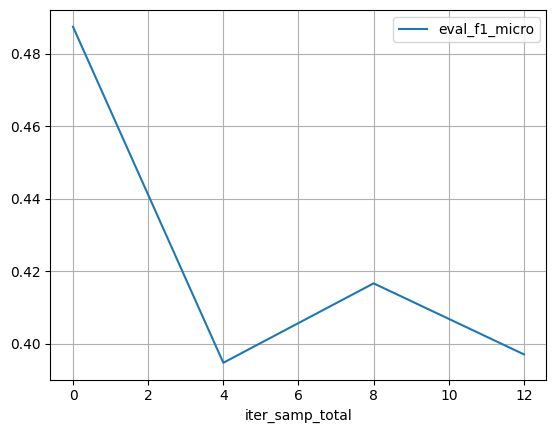

In [26]:
## plot metrics over iterations
metrics_dic_lst = []
n_sample = 0
for key_iter, value_metrics_dic in learner.metrics.items():
    metrics_dic_iter = {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["eval_label_gold_raw", "eval_label_predicted_raw"]}
    metrics_dic_iter = {"iter_samp_total": n_sample, **metrics_dic_iter}
    metrics_dic_lst.append(metrics_dic_iter)
    n_sample += N_SAMPLE_AL

df_metrics = pd.DataFrame(metrics_dic_lst)

df_metrics.plot(x="iter_samp_total", y="eval_f1_micro", grid=True)
#df_metrics.plot(x="iter_samp_total", y="f1_macro", grid=True)
#df_metrics.plot(x="iter_samp_total", y="eval_accuracy_balanced")



In [27]:
df_metrics

,iter_samp_total,eval_loss,eval_f1_macro,eval_f1_micro,eval_accuracy_balanced,eval_accuracy_not_b,eval_precision_macro,eval_recall_macro,eval_precision_micro,eval_recall_micro,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0,0.608154,0.401935,0.487500,0.487500,0.487500,0.373004,0.487500,0.487500,0.487500,53.9356,5.933,0.371,NaN
1,4,0.775449,0.371450,0.394737,0.394225,0.394737,0.396945,0.394225,0.394737,0.394737,48.4529,6.274,0.392,2.0
2,8,0.934098,0.332558,0.416667,0.413227,0.416667,0.358974,0.413227,0.416667,0.416667,42.5562,6.768,0.423,2.0
3,12,0.824044,0.318021,0.397059,0.379934,0.397059,0.328365,0.379934,0.397059,0.397059,46.2812,5.877,0.367,2.0


In [28]:
## merge predictions from learner with df_corpus and all meta-data
# get idx for last tested corpus for getting full df_corpus with all columns
df_corpus_test = df_corpus[df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]
df_corpus_test["label_pred"] = learner.iteration_label_predicted
# add probabilities, e.g. for data cleaning and interpretation downstream
df_corpus_test["label_probabilities"] = learner.iteration_probabilities
df_corpus_train = df_corpus[~df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]

df_corpus_concat = pd.concat([df_corpus_train, df_corpus_test])

# inspect predictions on test set
df_corpus_test[['label_text', 'label_pred', 'label_probabilities', "text_prepared"]]  # 'label_text_pred',

/var/folders/jt/1js1kpf96c991hb8zjzt0cjc0000gn/T/ipykernel_11597/859506242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus_test["label_pred"] = learner.iteration_label_predicted
/var/folders/jt/1js1kpf96c991hb8zjzt0cjc0000gn/T/ipykernel_11597/859506242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus_test["label_probabilities"] = learner.iteration_probabilities


,label_text,label_pred,label_probabilities,text_prepared
idx,,,,
0,immigration_neutral,3,"[0.859475314617157, 0.3675582706928253, 0.4314...",Encourage continued and increased strategic en...
1,immigration_neutral,3,"[0.8722743391990662, 0.6086118817329407, 0.547...",The work that is taking place in the Human Rig...
2,immigration_neutral,2,"[0.8811103701591492, 0.5936983227729797, 0.914...",We want a generous refugee policy where all pe...
3,immigration_neutral,0,"[0.9096310138702393, 0.8014920353889465, 0.603...",The actual budget available for development co...
5,immigration_neutral,0,"[0.8693198561668396, 0.6294196248054504, 0.821...",7.3.1 If the Bloc Québécois sees with a good e...
...,...,...,...,...
74,no_topic,3,"[0.7799193263053894, 0.45210015773773193, 0.54...",This is especially true in the proximity of sc...
75,no_topic,3,"[0.4629545509815216, 0.3311215937137604, 0.274...",We will develop democracy and influence for th...
76,no_topic,3,"[0.7620042562484741, 0.42178693413734436, 0.18...",The government uses the falling number of chil...
